In [804]:
import pandas as pd
import numpy as np

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

#import lgbm classifier
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

In [805]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [806]:
# combine train and test data into one dataframe
df = pd.concat([train_df, test_df], sort=False)

In [807]:
# seperate the cabin info
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['CabinNumber'] = df['Cabin'].str.split('/').str[1].fillna('-1').astype('int')
df['Side'] = df['Cabin'].str.split('/').str[2]

In [808]:
exp_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [809]:
# column for total money spent on ammenities
df['TotalMoneySpent'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall']+ df['Spa']+ df['VRDeck']

In [810]:
df = df.drop(['Cabin'], axis=1)

In [811]:
# seperate passenger id into group number
df['Group'] = df['PassengerId'].str.split('_').str[0].astype(int)

In [812]:
# find group size and add to dataframe
group_size = df.groupby('Group').size().reset_index(name='GroupSize')
df = df.merge(group_size, on='Group', how='left')

In [813]:
df['NoSpending'] = (df['TotalMoneySpent'] == 0).astype(int)

In [814]:
df['TravellingAlone'] = (df['GroupSize'] == 1).astype(int)

In [815]:
# fill with na where cabin number is -1
df['CabinNumber'] = df['CabinNumber'].replace(-1, np.nan)

In [816]:
home_planet_groups = df.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

In [817]:
idx=df[df['HomePlanet'].isna()][(df[df['HomePlanet'].isna()]['Group']).isin(home_planet_groups.index)].index

# Fill corresponding missing values
df.loc[idx,'HomePlanet']=df.iloc[idx,:]['Group'].map(lambda x: home_planet_groups.idxmax(axis=1)[x])

In [818]:
df['HomePlanet'].isna().sum()

157

<AxesSubplot:xlabel='Deck', ylabel='count'>

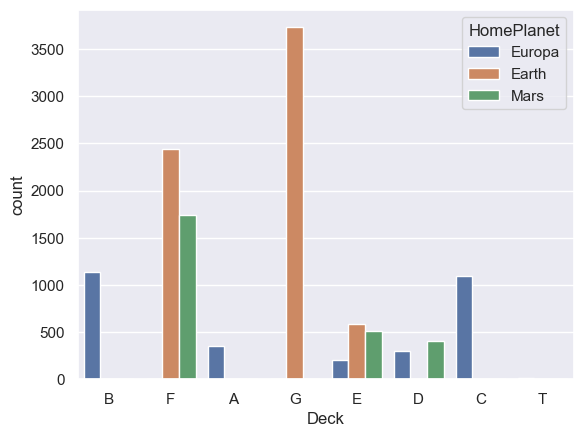

In [819]:
# plot deck and home planet

sns.set(style="darkgrid")
sns.countplot(x="Deck", hue="HomePlanet", data=df)

In [820]:
df.loc[(df['HomePlanet'].isna()) & (df['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

df.loc[(df['HomePlanet'].isna()) & (df['Deck']=='G'), 'HomePlanet']='Earth'

In [821]:
df['Surname']=df['Name'].str.split().str[-1]

In [822]:
df['Surname'].isna().sum()

294

In [823]:
groups = df.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
idx=df[df['HomePlanet'].isna()][(df[df['HomePlanet'].isna()]['Surname']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'HomePlanet']=df.iloc[idx,:]['Surname'].map(lambda x: groups.idxmax(axis=1)[x])

In [824]:
df.loc[(df['HomePlanet'].isna()) & ~(df['Deck']=='D'), 'HomePlanet']='Earth'
df.loc[(df['HomePlanet'].isna()) & (df['Deck']=='D'), 'HomePlanet']='Mars'

In [825]:
df['Destination'].isna().sum()

274

In [826]:
groups = df.groupby(['Surname','Destination'])['Destination'].size().unstack().fillna(0)
idx=df[df['Destination'].isna()][(df[df['Destination'].isna()]['Surname']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'Destination']=df.iloc[idx,:]['Surname'].map(lambda x: groups.idxmax(axis=1)[x])

In [827]:
df['Destination'].isna().sum()

8

In [828]:
groups = df.groupby(['Group','Destination'])['Destination'].size().unstack().fillna(0)
idx=df[df['Destination'].isna()][(df[df['Destination'].isna()]['Group']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'Destination']=df.iloc[idx,:]['Group'].map(lambda x: groups.idxmax(axis=1)[x])

In [829]:
df['Destination'].isna().sum()

6

In [830]:
# fill missing values with most common value for destination
df['Destination'].fillna(df['Destination'].mode()[0], inplace=True)

In [831]:
groups = df[df['GroupSize']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)
idx=df[df['Surname'].isna()][(df[df['Surname'].isna()]['Group']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'Surname']=df.iloc[idx,:]['Group'].map(lambda x: groups.idxmax(axis=1)[x])

In [832]:
df['Surname'].fillna('Unknown', inplace=True)

In [833]:
df['FamilySize']=df['Surname'].map(lambda x: df['Surname'].value_counts()[x])

In [834]:
df.loc[df['Surname']=='Unknown','Surname']=np.nan

df.loc[df['FamilySize']>100,'FamilySize']=0

In [835]:
len(df[df['Deck'].isna()])

299

In [836]:
groups = df[df['GroupSize']>1].groupby(['Group','Deck'])['Deck'].size().unstack().fillna(0)
idx=df[df['Deck'].isna()][(df[df['Deck'].isna()]['Group']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'Deck']=df.iloc[idx,:]['Group'].map(lambda x: groups.idxmax(axis=1)[x])

In [837]:
len(df[df['Deck'].isna()])

162

In [838]:
groups = df[df['GroupSize']>1].groupby(['Surname','Deck'])['Deck'].size().unstack().fillna(0)
idx=df[df['Deck'].isna()][(df[df['Deck'].isna()]['Surname']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'Deck']=df.iloc[idx,:]['Surname'].map(lambda x: groups.idxmax(axis=1)[x])

In [839]:
len(df[df['Deck'].isna()])

66

In [840]:
deck_na_rows=df.loc[df['Deck'].isna(),'Deck'].index
df.loc[df['Deck'].isna(),'Deck']=df.groupby(['HomePlanet','Destination','TravellingAlone'])['Deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[deck_na_rows]

In [841]:
len(df[df['Deck'].isna()])

0

In [842]:
len(df[df['Side'].isna()])

299

In [843]:
groups = df[df['GroupSize']>1].groupby(['Group','Side'])['Side'].size().unstack().fillna(0)
idx=df[df['Side'].isna()][(df[df['Side'].isna()]['Group']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'Side']=df.iloc[idx,:]['Group'].map(lambda x: groups.idxmax(axis=1)[x])

In [844]:
len(df[df['Side'].isna()])

162

In [845]:
groups = df[df['GroupSize']>1].groupby(['Surname','Side'])['Side'].size().unstack().fillna(0)
idx=df[df['Side'].isna()][(df[df['Side'].isna()]['Surname']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'Side']=df.iloc[idx,:]['Surname'].map(lambda x: groups.idxmax(axis=1)[x])

In [846]:
len(df[df['Side'].isna()])

66

In [847]:
len(df[df['CabinNumber'].isna()])

299

In [848]:
# fill missing cabin numbers through linear regression
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=df.loc[~(df['CabinNumber'].isna()) & (df['Deck']==deck),'Group']
    y_CN=df.loc[~(df['CabinNumber'].isna()) & (df['Deck']==deck),'CabinNumber']
    X_test_CN=df.loc[(df['CabinNumber'].isna()) & (df['Deck']==deck),'Group']

    # Linear regression
    model_CN = LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # Fill missing values with predictions
    df.loc[(df['CabinNumber'].isna()) & (df['Deck']==deck),'CabinNumber']=preds_CN.astype(int)

In [849]:
len(df[df['CabinNumber'].isna()])

0

In [850]:
df.loc[(df['CabinNumber']<300),'CabinNumberGroup']=0
df.loc[((df['CabinNumber']>=300) & (df['CabinNumber']<600)),'CabinNumberGroup']=1
df.loc[((df['CabinNumber']>=600) & (df['CabinNumber']<1200)),'CabinNumberGroup']=2
df.loc[(df['CabinNumber']>=1200),'CabinNumberGroup']=3

In [851]:
df['Side'].value_counts()

S    6504
P    6400
Name: Side, dtype: int64

In [852]:
# Fill missing values using the less common side
df.loc[df['Side'].isna(),'Side']='P'

In [853]:
len(df[df['Side'].isna()])

0

In [854]:
len(df[df['VIP'].isna()])

296

In [855]:
groups = df[df['GroupSize']>1].groupby(['Surname','VIP'])['VIP'].size().unstack().fillna(0)
idx=df[df['VIP'].isna()][(df[df['VIP'].isna()]['Surname']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'VIP']=df.iloc[idx,:]['Surname'].map(lambda x: groups.idxmax(axis=1)[x])

In [856]:
len(df[df['VIP'].isna()])

63

In [857]:
groups = df.groupby(['CabinNumber','VIP'])['VIP'].size().unstack().fillna(0)
idx=df[df['VIP'].isna()][(df[df['VIP'].isna()]['CabinNumber']).isin(groups.index)].index

# Fill corresponding missing values
df.loc[idx,'VIP']=df.iloc[idx,:]['CabinNumber'].map(lambda x: groups.idxmax(axis=1)[x])

In [858]:
len(df[df['VIP'].isna()])

1

In [859]:
df.loc[df['VIP'].isna(),'VIP']=False

In [860]:
len(df[df['Age'].isna()])

270

In [861]:
# Fill missing values using the median
age_na_rows=df.loc[df['Age'].isna(),'Age'].index
df.loc[df['Age'].isna(),'Age']=df.groupby(['HomePlanet','NoSpending','TravellingAlone','Deck'])['Age'].transform(lambda x: x.fillna(x.median()))[age_na_rows]

In [862]:
len(df[df['Age'].isna()])

0

In [863]:
df.loc[df['Age']<=12,'AgeGroup']=0
df.loc[(df['Age']>12) & (df['Age']<18),'AgeGroup']=1
df.loc[(df['Age']>=18) & (df['Age']<=25),'AgeGroup']=2
df.loc[(df['Age']>25) & (df['Age']<=30),'AgeGroup']=3
df.loc[(df['Age']>30) & (df['Age']<=50),'AgeGroup']=4
df.loc[df['Age']>50,'AgeGroup']=5

In [864]:
len(df[df['CryoSleep'].isna()])

310

In [865]:
na_rows=df.loc[df['CryoSleep'].isna(),'CryoSleep'].index
df.loc[df['CryoSleep'].isna(),'CryoSleep']=df.groupby(['NoSpending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows]

In [866]:
len(df[df['CryoSleep'].isna()])

0

In [867]:
for col in exp_cols:
    df.loc[(df[col].isna()) & (df['CryoSleep']==True), col]=0

In [868]:
for col in exp_cols:
    na_rows=df.loc[df[col].isna(),col].index
    df.loc[df[col].isna(),col]=df.groupby(['HomePlanet','TravellingAlone','AgeGroup'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]

In [869]:
df['TotalMoneySpent']=df[exp_cols].sum(axis=1)
df['NoSpending']=(df['TotalMoneySpent']==0).astype(int)

In [870]:
df.loc[df['Name'].isna(),'Name']='Unknown'
df.loc[df['Surname'].isna(),'Surname']='Unknown'

In [871]:
df.isna().sum()

PassengerId            0
HomePlanet             0
CryoSleep              0
Destination            0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
Name                   0
Transported         4277
Deck                   0
CabinNumber            0
Side                   0
TotalMoneySpent        0
Group                  0
GroupSize              0
NoSpending             0
TravellingAlone        0
Surname                0
FamilySize             0
CabinNumberGroup       0
AgeGroup               0
dtype: int64

In [872]:
df['CryoSleep'] = df['CryoSleep'].astype(int)

In [873]:
df['Destination'].value_counts()

TRAPPIST-1e      9095
55 Cancri e      2685
PSO J318.5-22    1190
Name: Destination, dtype: int64

In [874]:
df.loc[df['Destination'] == 'TRAPPIST-1e','Destination']=0
df.loc[df['Destination'] == '55 Cancri e','Destination']=1
df.loc[df['Destination'] == 'PSO J318.5-22','Destination']=2

In [875]:
df['HomePlanet'].value_counts()

Earth     7019
Europa    3197
Mars      2754
Name: HomePlanet, dtype: int64

In [876]:
df.loc[df['HomePlanet'] == 'Earth','HomePlanet']=0
df.loc[df['HomePlanet'] == 'Europa','HomePlanet']=1
df.loc[df['HomePlanet'] == 'Mars','HomePlanet']=2

In [877]:
df['Deck'].value_counts()

F    4309
G    3899
E    1344
B    1174
C    1135
D     734
A     364
T      11
Name: Deck, dtype: int64

In [878]:
df.loc[df['Deck'] == 'A','Deck']=0
df.loc[df['Deck'] == 'B','Deck']=1
df.loc[df['Deck'] == 'C','Deck']=2
df.loc[df['Deck'] == 'D','Deck']=3
df.loc[df['Deck'] == 'E','Deck']=4
df.loc[df['Deck'] == 'F','Deck']=5
df.loc[df['Deck'] == 'G','Deck']=6
df.loc[df['Deck'] == 'T','Deck']=7

In [879]:
df['Side'].value_counts()

S    6504
P    6466
Name: Side, dtype: int64

In [880]:
df.loc[df['Side'] == 'S','Side']=0
df.loc[df['Side'] == 'P','Side']=1

In [797]:
df[['VIP', 'HomePlanet', 'Destination', 'Deck', 'Side', 'CabinNumberGroup', 'AgeGroup']] = df[['VIP', 'HomePlanet', 'Destination', 'Deck', 'Side', 'CabinNumberGroup', 'AgeGroup']].astype(int)

In [881]:
df.to_csv('unclean_data.csv', index=False)

In [887]:
df = pd.read_csv('unclean_data.csv')

In [888]:
DEFAULT_SURVIVAL_VALUE = 0.5
df['FamilySurvival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in df.groupby(['Surname', 'Group']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Transported'].max()
            smin = grp_df.drop(ind)['Transported'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df.loc[df['PassengerId'] == passID, 'FamilySurvival'] = 1
            elif (smin==0.0):
                df.loc[df['PassengerId'] == passID, 'FamilySurvival'] = 0

In [889]:
df.drop(['Name','Surname','CabinNumber','Age', 'PassengerId', 'Group'],axis=1,inplace=True)

In [890]:
for col in exp_cols:
    df[col]=np.log(1+df[col])

In [891]:
df['TotalMoneySpent']=np.log(1+df['TotalMoneySpent'])

In [892]:
# split df in train and test
train=df.loc[~df['Transported'].isna()]
test=df.loc[df['Transported'].isna()]

In [893]:
train['Transported'] = train['Transported'].astype(int)

C:\Users\HP\AppData\Local\Temp\ipykernel_10604\32068924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Transported'] = train['Transported'].astype(int)


In [894]:
train.corr()['Transported'].sort_values(ascending=False)

Transported         1.000000
NoSpending          0.482416
CryoSleep           0.466889
HomePlanet          0.119111
FamilySurvival      0.101840
GroupSize           0.082644
Destination         0.069164
VIP                -0.037261
CabinNumberGroup   -0.050732
FamilySize         -0.050855
AgeGroup           -0.085742
Side               -0.103377
TravellingAlone    -0.113792
Deck               -0.119337
FoodCourt          -0.142482
ShoppingMall       -0.188929
VRDeck             -0.345165
RoomService        -0.365200
Spa                -0.369219
TotalMoneySpent    -0.471069
Name: Transported, dtype: float64

In [895]:
X = train.drop(['Transported'], axis=1)
test = test.drop(['Transported'], axis=1)

Y = train['Transported']

In [896]:
# Logistic Regression

logreg = LogisticRegression( solver='lbfgs', max_iter=1000)
logreg_cv_scores = cross_val_score(logreg, X, Y, cv=5)
print("Logistic Regression Accuracy: %0.2f (+/- %0.2f)" % (logreg_cv_scores.mean() * 100, logreg_cv_scores.std() * 100))
log_reg_Y_pred = logreg.fit(X, Y).predict(test)

Logistic Regression Accuracy: 77.05 (+/- 0.56)


In [897]:
A = np.column_stack((log_reg_Y_pred,))

In [899]:
# Support Vector Machines

svc = SVC()
svc_cv_scores = cross_val_score(svc, X, Y, cv=5)
print("Support Vector Machines Accuracy: %0.2f (+/- %0.2f)" % (svc_cv_scores.mean() * 100, svc_cv_scores.std() * 100))
svc_Y_pred = svc.fit(X, Y).predict(test)

Support Vector Machines Accuracy: 79.21 (+/- 1.05)


In [900]:
A = np.column_stack((A,svc_Y_pred))

In [901]:
# KNN

knn = KNeighborsClassifier(n_neighbors = 50)
knn_cv_scores = cross_val_score(knn, X, Y, cv=5)
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (knn_cv_scores.mean() * 100, knn_cv_scores.std() * 100))
knn_Y_pred = knn.fit(X, Y).predict(test)

KNN Accuracy: 78.22 (+/- 1.12)


In [902]:
A = np.column_stack((A,knn_Y_pred))

In [903]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian_cv_scores = cross_val_score(gaussian, X, Y, cv=5)
print("Gaussian Naive Bayes Accuracy: %0.2f (+/- %0.2f)" % (gaussian_cv_scores.mean() * 100, gaussian_cv_scores.std() * 100))
gaussian_Y_pred = gaussian.fit(X, Y).predict(test)

Gaussian Naive Bayes Accuracy: 73.61 (+/- 1.23)


In [904]:
A = np.column_stack((A,gaussian_Y_pred))

In [905]:
# Perceptron

perceptron = Perceptron()
perceptron_cv_scores = cross_val_score(perceptron, X, Y, cv=5)
print("Perceptron Accuracy: %0.2f (+/- %0.2f)" % (perceptron_cv_scores.mean() * 100, perceptron_cv_scores.std() * 100))
perceptron_Y_pred = perceptron.fit(X, Y).predict(test)

Perceptron Accuracy: 72.40 (+/- 2.01)


In [906]:
A = np.column_stack((A,perceptron_Y_pred))

In [907]:
# Linear SVC

linear_svc = LinearSVC(max_iter=1000, verbose=0)
linear_svc_cv_scores = cross_val_score(linear_svc, X, Y, cv=5)
print("Linear SVC Accuracy: %0.2f (+/- %0.2f)" % (linear_svc_cv_scores.mean() * 100, linear_svc_cv_scores.std() * 100))
linear_svc_Y_pred = linear_svc.fit(X, Y).predict(test)

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC Accuracy: 76.87 (+/- 0.92)


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [908]:
A = np.column_stack((A,linear_svc_Y_pred))

In [909]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd_cv_scores = cross_val_score(sgd, X, Y, cv=5)
print("Stochastic Gradient Descent Accuracy: %0.2f (+/- %0.2f)" % (sgd_cv_scores.mean() * 100, sgd_cv_scores.std() * 100))
sgd_Y_pred = sgd.fit(X, Y).predict(test)

Stochastic Gradient Descent Accuracy: 71.19 (+/- 4.10)


In [910]:
A = np.column_stack((A,sgd_Y_pred))

In [911]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=1000)
random_forest_cv_scores = cross_val_score(random_forest, X, Y, cv=5)
print("Random Forest Accuracy: %0.2f (+/- %0.2f)" % (random_forest_cv_scores.mean() * 100, random_forest_cv_scores.std() * 100))
random_forest_Y_pred = random_forest.fit(X, Y).predict(test)

Random Forest Accuracy: 79.51 (+/- 2.06)


In [912]:
A = np.column_stack((A,random_forest_Y_pred))

In [913]:
# XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X, Y, cv=5)
print("XGBoost Accuracy: %0.2f (+/- %0.2f)" % (xgb_cv_scores.mean() * 100, xgb_cv_scores.std() * 100))
xgb_Y_pred = xgb_model.fit(X, Y).predict(test)

XGBoost Accuracy: 79.62 (+/- 2.46)


In [914]:
A = np.column_stack((A,xgb_Y_pred))

In [915]:
# lightgbm
lgbm_model = lgb.LGBMClassifier(objective="binary", learning_rate=0.05, n_estimators=100, max_depth=10, random_state=0)
lgbm_cv_scores = cross_val_score(lgbm_model, X, Y, cv=5)
print("lightgbm Accuracy: %0.2f (+/- %0.2f)" % (lgbm_cv_scores.mean() * 100, lgbm_cv_scores.std() * 100))
lgbm_Y_pred = lgbm_model.fit(X, Y).predict(test)

lightgbm Accuracy: 80.42 (+/- 2.60)


In [916]:
A = np.column_stack((A,lgbm_Y_pred))

In [917]:
# catboost
cat_model = cb.CatBoostClassifier(learning_rate=0.15, n_estimators=100, depth=4, loss_function='Logloss', verbose=0)
cat_cv_scores = cross_val_score(cat_model, X, Y, cv=5)
print("catboost Accuracy: %0.2f (+/- %0.2f)" % (cat_cv_scores.mean() * 100, cat_cv_scores.std() * 100))
cat_Y_pred = cat_model.fit(X, Y).predict(test)

catboost Accuracy: 80.43 (+/- 1.43)


In [918]:
A = np.column_stack((A,cat_Y_pred))

In [919]:
avg = np.round(np.mean(A, axis=1)).astype(bool)

In [920]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',

                'Random Forest', 'Naive Bayes', 'Perceptron',

                'Stochastic Gradient Decent', 'Linear SVC', 'XGBoost', 'lightgbm', 'catboost'],
    'Training Accuracy': [svc_cv_scores.mean() * 100, knn_cv_scores.mean() * 100, logreg_cv_scores.mean() * 100,


                random_forest_cv_scores.mean() * 100, gaussian_cv_scores.mean() * 100, perceptron_cv_scores.mean() * 100,

                sgd_cv_scores.mean() * 100, linear_svc_cv_scores.mean() * 100, xgb_cv_scores.mean() * 100, lgbm_cv_scores.mean() * 100, cat_cv_scores.mean() * 100]})
result_df = results.sort_values(by='Training Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Training Accuracy
Model,
catboost,80.432844
lightgbm,80.421489
XGBoost,79.616111
Random Forest,79.512570
Support Vector Machines,79.213422
KNN,78.224103
Logistic Regression,77.050571
Linear SVC,76.866637
Naive Bayes,73.611264


In [928]:
A = np.column_stack((lgbm_Y_pred,cat_Y_pred, xgb_Y_pred))

In [929]:
avg = np.round(np.mean(A, axis=1)).astype(bool)

In [930]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Transported": avg
    })
submission.to_csv('final.csv', index=False)